In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from train_dynamics import FlowModel
from train_dynamics import load_score_model
from turing_pattern import GrayScottSimulator, create_random_state, TuringPatternDataset
from tqdm import tqdm
from alifes import RandomImagesDataset

from training_free import training_free_flow, sde_solve
from visulization import TuringPlotter, plot_trace

# Set matplotlib to use STIX fonts for better LaTeX compatibility
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 10

In [ ]:
r = 0
num_channel = 3

results = {}
# name = 'sym'
for name in ['sym', 'taiji', 'dot', 'dots']:
    print(f'Simulating {name}...')
    # set random seed
    torch.manual_seed(0)

    # initialize the kernel and model
    p = torch.randn(num_channel, num_channel, 2*r+1, 2*r+1)
    k = p - p.transpose(0, 1).flip(-1, -2)
    k = k / k.norm()
    f, score, dataset, scheduler = training_free_flow(name=name, task='alifes', num_channel=3, k=k, t=10)
    x0 = dataset[0].cuda().unsqueeze(0)

    # simulate the dynamics
    torch.manual_seed(0)
    x0 = torch.rand(1, 3, 256, 256).cuda() * 2 - 1
    T = 2000
    trace, trace_pred = sde_solve(f, score, scheduler, x0, T, dt=0.05, eta=0.1, v_factor=1)
    sim_results = dataset.denormalize(trace_pred)
    results[name] = sim_results

Simulating sym...


100%|██████████| 2000/2000 [00:59<00:00, 33.85it/s]


Simulating taiji...


100%|██████████| 2000/2000 [00:58<00:00, 34.05it/s]


Simulating dot...


100%|██████████| 2000/2000 [00:58<00:00, 34.31it/s]


Simulating dots...


100%|██████████| 2000/2000 [00:58<00:00, 34.23it/s]


In [217]:
r = 0
num_channel = 3

name = 'dots'

torch.manual_seed(0)

# initialize the kernel and model
p = torch.randn(num_channel, num_channel, 2*r+1, 2*r+1)
k = p - p.transpose(0, 1).flip(-1, -2)
k = k / k.norm()
f, score, dataset, scheduler = training_free_flow(name=name, task='alifes', num_channel=3, k=k, t=10)
x0 = dataset[0].cuda().unsqueeze(0)

# simulate the dynamics
torch.manual_seed(0)
x0 = torch.rand(1, 3, 256, 256).cuda() * 2 - 1
T = 2000
trace, trace_pred = sde_solve(f, score, scheduler, x0, T, dt=0.05, eta=0.1, v_factor=1)
sim_results = dataset.denormalize(trace_pred)
results[name] = sim_results

100%|██████████| 2000/2000 [00:58<00:00, 34.31it/s]


In [220]:
torch.save(results, './alifes/data/sim_results.pt')

In [2]:
results = torch.load('./alifes/data/sim_results.pt')

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_ema_frame(sim_results, eta=0.99, frame_idx=0, traj=None,
                   ax=None, insert_img: str=None, overlay_size: float=0.125,
                   corner: str="upper left", pad: float=0.02, overlay_alpha: float=1.0):
    """
    Plot EMA frame on the specified ax and overlay an inset image.

    Parameters:
      ax            : matplotlib Axes to plot on. If None, uses current axis.
      overlay_size  : width and height of overlay in axis coordinates (relative proportion to axis, 0~1).
      corner        : 'upper left' / 'upper right' / 'lower left' / 'lower right'
      pad           : padding distance from edges (axis coordinates, 0~1)
    """
    if ax is None:
        ax = plt.gca()

    T = sim_results.shape[0]
    frame_idx = int(np.clip(frame_idx, 0, T - 1))

    # --- Compute EMA frame ---
    ema_img = sim_results[0, 0].permute(1, 2, 0).numpy().clip(0, 1)
    for t in range(1, frame_idx + 1):
        frame = sim_results[t, 0].permute(1, 2, 0).numpy().clip(0, 1)
        ema_img = ema_img * eta + frame * (1 - eta)

    # --- Main plot ---
    ax.imshow(ema_img)
    ax.set_axis_off()
    
    # --- Trajectory ---
    if traj is not None:
        for t in traj:
            if t['t_end'] - t['t_start'] > 200:
                corr = np.array(t['corr'])
                # Re-sample the corr to 20 points
                n_points = len(corr)
                if n_points > 20:
                    indices = np.linspace(0, n_points - 1, 20).astype(int)
                    corr = corr[indices]
                
                color_end = "#E93A01"
                color_start = "#46B3D5"
                
                ax.plot(corr[:, 0], corr[:, 1], color='#FFFFFF', alpha=0.5, linewidth=2, zorder=3)
                ax.plot(corr[:, 0], corr[:, 1], color='#A2CFC3', alpha=1, linewidth=1, zorder=4)
    # Add a circle at the end of the trajectory
    if traj is not None:
        for t in traj:
            if t['t_end'] - t['t_start'] > 200:
                corr = np.array(t['corr'])
                ax.plot(corr[-1, 0], corr[-1, 1], 'o', color=color_end, alpha=0.5, zorder=3, markersize=2)
                
    # --- Insert image ---
    if insert_img is not None:
        img = Image.open(insert_img).convert("RGBA")
        # Convert to RGB with white background
        white_bg = Image.new("RGB", img.size, "white")
        white_bg.paste(img, mask=img.split()[-1])  # Use alpha channel as mask
        img = white_bg

        # Choose the corner & position (axis coordinates: bottom-left is (0,0), top-right is (1,1))
        w = h = overlay_size
        corners = {
            "upper left":  (pad, 1 - pad - h),
            "upper right": (1 - pad - w, 1 - pad - h),
            "lower left":  (pad, pad),
            "lower right": (1 - pad - w, pad),
        }
        x0, y0 = corners.get(corner, (pad, 1 - pad - h))

        iax = ax.inset_axes([x0, y0, w, h])
        iax.imshow(img, alpha=overlay_alpha)
        iax.set_xticks([])
        iax.set_yticks([])
        iax.set_zorder(ax.get_zorder() + 5)

    return ax

In [7]:
def ema_movie(sim_result, eta=0.99):
    x = sim_result[0]
    traj = []
    for frame in sim_result:
        x = x * eta + frame * (1 - eta)
        traj.append(x)
    return torch.stack(traj, dim=0)

Tracking:   0%|          | 0/450 [00:00<?, ?it/s]

Tracking:   0%|          | 0/450 [00:00<?, ?it/s]

Tracking:   0%|          | 0/450 [00:00<?, ?it/s]

Tracking:   0%|          | 0/450 [00:00<?, ?it/s]

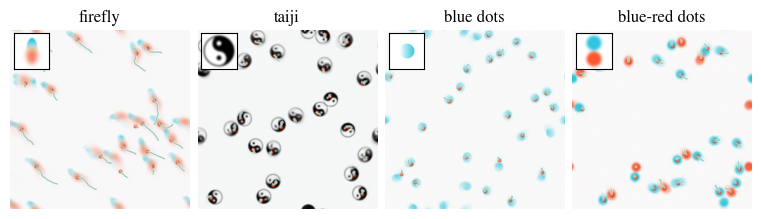

In [ ]:
from tracker import BlobTracker

fig, axes = plt.subplots(1, 4, figsize=(7.5, 3), constrained_layout=True)

plot_parameters = {
    'sym':   {'eta': 0.99,  'frame_idx': 1500, 'title': 'firefly'},
    'taiji': {'eta': 0.99,  'frame_idx': 500,  'title': 'taiji'},
    'dot':   {'eta': 0.99, 'frame_idx': 500, 'title': 'blue dots'},
    'dots':  {'eta': 0.99,  'frame_idx': 1000,  'title': 'blue-red dots'}
}

tracker = BlobTracker(
    blur_sigma=2.0,
    min_area=16,
    max_area=128,
    min_dist=8,
    max_move=16,
    max_miss=128
)

for i, (name, params) in enumerate(plot_parameters.items()):
    r, c = divmod(i, 4)
    try:
        ax = axes[r, c]
    except:
        ax = axes[i]
    
    frame = ema_movie(results[name][params['frame_idx']-450:params['frame_idx']], eta=params['eta'])
    traj_list = tracker.track(frame)
    plot_ema_frame(
        results[name],
        eta=params['eta'],
        frame_idx=params['frame_idx'],
        ax=ax,
        traj=traj_list,
        insert_img=f'./alifes/images/{name}.png',
        overlay_size=0.2,
        corner="upper left", pad=0.02,
        overlay_alpha=1.0
    )
    ax.set_title(params['title'])

plt.savefig('./alifes/figures/alifes.pdf', bbox_inches='tight')
plt.show()

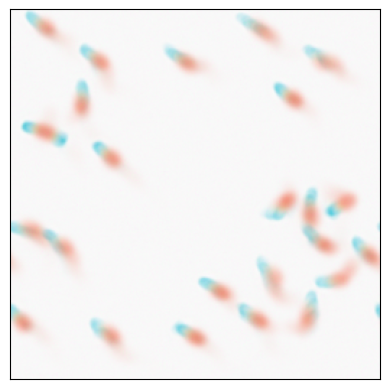

In [28]:
plot_ema_frame(
        results['sym'],
        eta=params['eta'],
        frame_idx=params['frame_idx'],
    )
plt.axis('on')
plt.xticks([]); plt.yticks([])
plt.savefig('../cover/sym_recovered.pdf', bbox_inches='tight')
plt.show()

In [148]:
import os
import cv2

def get_video_dimensions(sim_results):
    """Extract video dimensions from simulation results."""
    first_frame = sim_results[0, 0].permute(1, 2, 0).numpy().clip(0, 1)
    height, width = first_frame.shape[:2]
    return height, width

def try_create_video_writer(output_path, fps, width, height, quality='medium'):
    """Try different codecs to create video writer with quality settings."""
    # Quality settings for different codecs
    quality_settings = {
        'low': {'bitrate': 1000, 'crf': 28},
        'medium': {'bitrate': 2500, 'crf': 23},
        'high': {'bitrate': 5000, 'crf': 18},
        'ultra': {'bitrate': 10000, 'crf': 15}
    }
    
    # Try different codecs in order of preference
    codecs = ['mp4v', 'XVID', 'avc1']
    
    for codec in codecs:
        try:
            fourcc = cv2.VideoWriter_fourcc(*codec)
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
            if out.isOpened():
                return out
            out.release()
        except:
            continue
    
    raise RuntimeError("Failed to initialize video writer with any codec")

def create_video_from_results(sim_results, output_path, fps=30, quality='medium'):
    """Create MP4 video from simulation results with specified quality."""
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    height, width = get_video_dimensions(sim_results)
    out = try_create_video_writer(output_path, fps, width, height, quality)
    return out, height, width

def initialize_ema_frame(sim_results):
    """Initialize EMA frame with first frame."""
    return sim_results[0, 0].permute(1, 2, 0).numpy().clip(0, 1)

def update_ema_frame(ema_img, frame_tensor, eta):
    """Update EMA frame with new frame."""
    frame = frame_tensor.permute(1, 2, 0).numpy().clip(0, 1)
    return ema_img * eta + frame * (1 - eta)

def convert_frame_to_bgr(frame):
    """Convert frame to BGR format for video writing."""
    frame_uint8 = (frame * 255).astype('uint8')
    return cv2.cvtColor(frame_uint8, cv2.COLOR_RGB2BGR)

def process_and_write_frames_with_ema(sim_results, out, eta=0.995):
    """Process simulation results with EMA and write frames to video."""
    ema_img = initialize_ema_frame(sim_results)
    
    for t in range(len(sim_results)):
        ema_img = update_ema_frame(ema_img, sim_results[t, 0], eta)
        frame_bgr = convert_frame_to_bgr(ema_img)
        out.write(frame_bgr)

def finalize_video(out, output_path):
    """Release video writer and print completion message."""
    out.release()
    cv2.destroyAllWindows()
    print(f"Video saved to {output_path}")

# Create video from simulation results with EMA
# Available quality options: 'low', 'medium', 'high', 'ultra'
video_quality = 'high'  # Change this to adjust video quality
output_path = f'./alifes/videos/simulation_{name}.mp4'
out, height, width = create_video_from_results(sim_results, output_path, fps=240, quality=video_quality)
process_and_write_frames_with_ema(sim_results, out, eta=0.9)
finalize_video(out, output_path)

Video saved to ./alifes/videos/simulation_sym.mp4


In [219]:
for name in results.keys():
    video_quality = 'high'  # Change this to adjust video quality
    output_path = f'./alifes/videos/simulation_{name}.mp4'
    out, height, width = create_video_from_results(results[name], output_path, fps=240, quality=video_quality)
    process_and_write_frames_with_ema(results[name], out, eta=0.9)
    finalize_video(out, output_path)

Video saved to ./alifes/videos/simulation_sym.mp4
Video saved to ./alifes/videos/simulation_taiji.mp4
Video saved to ./alifes/videos/simulation_dot.mp4
Video saved to ./alifes/videos/simulation_dots.mp4
